In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.datasets 
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
import os

# Setting up the Dataset & Workflow

In [2]:
# Path to the folder where the datasets are/should be downloaded 
DATASET_PATH = "./data/dogs-cats/"

# Function for setting the seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


# Transforms

In [3]:
# Define transforms for the training data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

# Define transforms for the test data
test_transforms = transforms.Compose([transforms.Resize(255),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

# DataLoaders --- Spliting

In [4]:
train_data = torchvision.datasets.ImageFolder(DATASET_PATH + '/train', transform=train_transforms)
test_data = torchvision.datasets.ImageFolder(DATASET_PATH + '/test', transform=test_transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100)

# Veryfing our normalization

In [5]:
imgs, labels = next(iter(train_loader))
print("Batch mean", imgs.mean(dim=[0,2,3]))
print("Batch std", imgs.std(dim=[0,2,3]))

Batch mean tensor([-0.0443, -0.0849,  0.0321])
Batch std tensor([1.1972, 1.1865, 1.1751])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3785625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7731092..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input da

ValueError: num must be an integer with 1 <= num <= 20, not 21

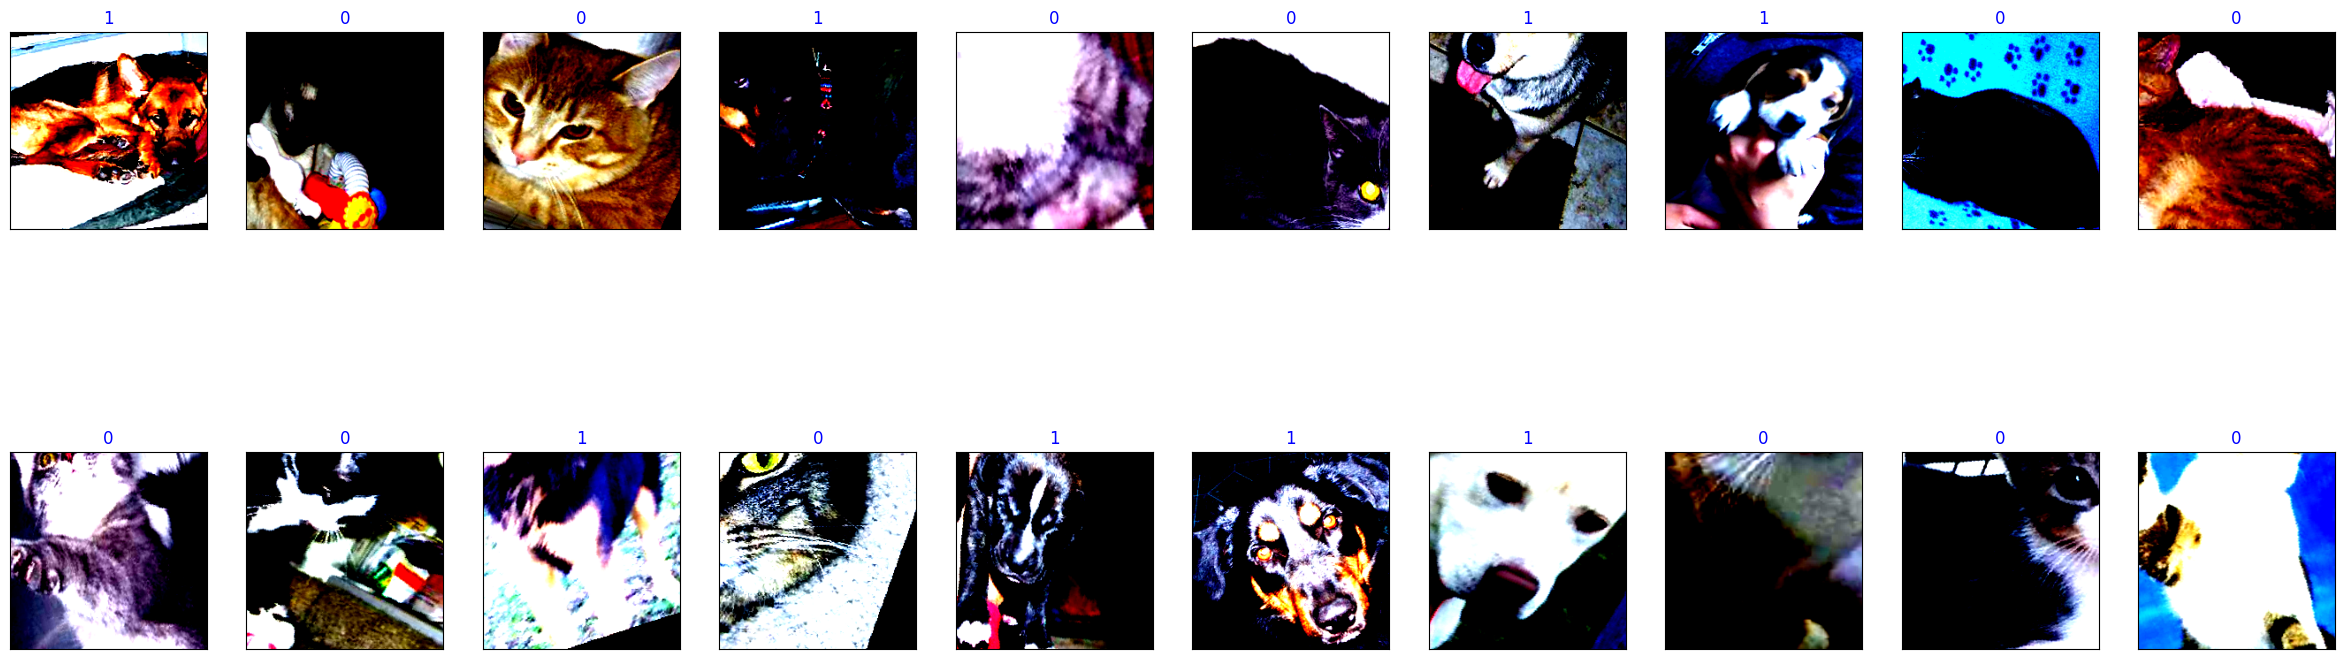

In [6]:
fig = plt.figure(figsize=(30, 10))
for i in range(len(labels)):
    ax = fig.add_subplot(2, 10, i + 1, xticks=[], yticks=[])
    # Transpose the image data to (height, width, channels)
    img_data = np.transpose(imgs[i], (1, 2, 0))
    plt.imshow(img_data)
    ax.set_title(labels[i].item(), color='blue')

plt.show()

Label: [0 0 0 1 1 0 0 1 1 1 1 0 0 1 1 1 0 0 1 0 1 0 1 0 0 0 1 0 1 0 1 1 0 1 1 0 1
 1 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 1 0 0
 1 0 1 0 0 0 0 1 0 1 1 0 1 0 0 0 0 1 0 1 0 1 0 0 1 1]
Class: CAT CAT CAT DOG DOG CAT CAT DOG DOG DOG DOG CAT CAT DOG DOG DOG CAT CAT DOG CAT DOG CAT DOG CAT CAT CAT DOG CAT DOG CAT DOG DOG CAT DOG DOG CAT DOG DOG DOG CAT CAT CAT DOG DOG DOG CAT CAT DOG CAT CAT CAT CAT DOG CAT DOG DOG CAT CAT CAT CAT CAT CAT CAT DOG DOG CAT DOG CAT DOG DOG CAT DOG CAT CAT DOG CAT DOG CAT CAT CAT CAT DOG CAT DOG DOG CAT DOG CAT CAT CAT CAT DOG CAT DOG CAT DOG CAT CAT DOG DOG


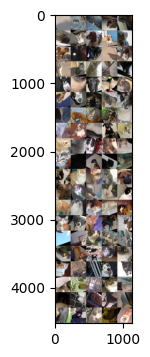

In [7]:
class_names = ["CAT", "DOG"]
# First batch of 100 images
for images,labels in train_loader:
    break

print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

# Making our CNN

In [8]:
class DogsCatsCNN(nn.Module):
    def __init__(self):
        super(DogsCatsCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(16*54*54, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        

In [9]:
model = DogsCatsCNN()
print(model)

DogsCatsCNN(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


In [10]:
model = DogsCatsCNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
def train_model(model, num_epochs=117):
    train_loss=0.0
    train_correct=0

    # For plotting purposes
    loss_keeper={'train':[]}
    
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for imgs, labels in train_loader:
            model.train()
            # Step 1: Move input data to device
            imgs, labels = imgs.to(device), labels.to(device)
            # Step 2: Run the model on the input data
            output = model(imgs)
            output = output.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]
            # Step 3: Calculate the loss
            loss = loss_fn(output, labels)
            # Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()
            # Step 5: Update the parameters
            optimizer.step()

            #Tracking Loss and Accuracy
            train_loss+=loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            train_correct+=pred.eq(labels.view_as(pred)).sum().item()

        train_loss = train_loss/len(train_loader)

        loss_keeper['train'].append(train_loss)
        
        print(f"\nEpoch : {epoch+1}\tTraining Loss : {train_loss}\t Accuracy : {100 * train_correct / len(labels)}")
        model_name=type(model).__name__
        torch.save(model.state_dict(), model_name+'_model.pth')
    return(loss_keeper)

In [12]:
m_loss = train_model(model)

  0%|          | 0/117 [00:00<?, ?it/s]


Epoch : 1	Training Loss : 0.6679884651303292	 Accuracy : 13230.337078651686

Epoch : 2	Training Loss : 0.6229197659388184	 Accuracy : 27966.29213483146

Epoch : 3	Training Loss : 0.6054390428852513	 Accuracy : 43005.61797752809

Epoch : 4	Training Loss : 0.5929130141727087	 Accuracy : 58314.606741573036

Epoch : 5	Training Loss : 0.5755481030666788	 Accuracy : 73960.67415730337

Epoch : 6	Training Loss : 0.5695168903003752	 Accuracy : 89711.23595505618

Epoch : 7	Training Loss : 0.5649099619341545	 Accuracy : 105533.70786516854

Epoch : 8	Training Loss : 0.5504682025170091	 Accuracy : 121560.67415730337

Epoch : 9	Training Loss : 0.5533800269468903	 Accuracy : 137605.61797752808

Epoch : 10	Training Loss : 0.5485347627825062	 Accuracy : 153725.8426966292

Epoch : 11	Training Loss : 0.5364233552511665	 Accuracy : 170000.0

Epoch : 12	Training Loss : 0.5316023211176675	 Accuracy : 186389.88764044945

Epoch : 13	Training Loss : 0.5320041273437418	 Accuracy : 202779.77528089887

Epoch : 1

In [13]:
model.load_state_dict(torch.load('DogsCatsCNN_model.pth'))

C:\Users\top\AppData\Local\Temp\ipykernel_5640\2431316381.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('DogsCatsCNN_model.pth'))


<All keys matched successfully>

In [33]:
def test_model(model):
    dog_probs = []
    model.eval()
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            preds = model(imgs)
            preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
            dog_probs += list(zip(list(labels), preds_list))
    return dog_probs
            

In [36]:
dog_probs = test_model(model)

In [37]:
dog_probs.sort(key = lambda x: int(x[0]))
dog_probs

[(tensor(0), 0.222252756357193),
 (tensor(0), 0.23491573333740234),
 (tensor(0), 0.05498204007744789),
 (tensor(0), 0.35809803009033203),
 (tensor(0), 0.9391490817070007),
 (tensor(0), 0.44436100125312805),
 (tensor(0), 0.07787603884935379),
 (tensor(0), 0.0026111581828445196),
 (tensor(0), 0.10961075127124786),
 (tensor(0), 0.11096256971359253),
 (tensor(0), 0.00277905585244298),
 (tensor(0), 0.4454718828201294),
 (tensor(0), 0.10324292629957199),
 (tensor(0), 0.7198125720024109),
 (tensor(0), 0.14950190484523773),
 (tensor(0), 0.7607870697975159),
 (tensor(0), 0.1121450662612915),
 (tensor(0), 0.09197519719600677),
 (tensor(0), 0.9038993120193481),
 (tensor(0), 0.7273789644241333),
 (tensor(0), 0.5652505159378052),
 (tensor(0), 0.6628789305686951),
 (tensor(0), 0.04062361642718315),
 (tensor(0), 0.13856059312820435),
 (tensor(0), 0.01031277235597372),
 (tensor(0), 0.7341979742050171),
 (tensor(0), 0.615664005279541),
 (tensor(0), 0.47265124320983887),
 (tensor(0), 0.07348842173814774

# Pretrained models (ResNet/GoogLeNet)

In [59]:
from torchvision import models

resnet = models.resnet18(pretrained=True)
googlenet = models.googlenet(pretrained=True)

In [60]:
num_classes = 2
num_features_resnet = resnet.fc.in_features
num_features_googlenet = googlenet.fc.in_features
resnet.fc = nn.Sequential(nn.Linear(num_features_resnet,512),
                                  nn.ReLU(),
                                  nn.Dropout(),
                                  nn.Linear(512, num_classes))
googlenet.fc = nn.Sequential(nn.Linear(num_features_googlenet,512),
                                  nn.ReLU(),
                                  nn.Dropout(),
                                  nn.Linear(512, num_classes))

In [83]:
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
def train_model(model, num_epochs=10):
    train_loss = 0.0
    loss_keeper={'train':[]}
    model.train()
    for epoch in tqdm(range(num_epochs)):
        for imgs, labels in train_loader:
            optimizer.zero_grad()
            imgs, labels = imgs.to(device), labels.to(device)
            output = model(imgs)
            loss = loss_fn(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.data.item() * imgs.size(0)
        train_loss /= len(train_loader.dataset)
        loss_keeper['train'].append(train_loss)
            
        print(f"\nEpoch : {epoch+1}\tTraining Loss : {train_loss}")
        model_name=type(model).__name__
        torch.save(model.state_dict(), model_name+'_model.pth')
    return (loss_keeper)

In [84]:
resnet.to(device)
res_loss = train_model(resnet)

  0%|          | 0/10 [00:00<?, ?it/s]


Epoch : 1	Training Loss : 0.16392439501117315

Epoch : 2	Training Loss : 0.15643613068546244

Epoch : 3	Training Loss : 0.1511268669948144

Epoch : 4	Training Loss : 0.14737980770845285

Epoch : 5	Training Loss : 0.14271042226402608

Epoch : 6	Training Loss : 0.1407218059929173

Epoch : 7	Training Loss : 0.14552077405506955

Epoch : 8	Training Loss : 0.13487973567362851

Epoch : 9	Training Loss : 0.13617202016766375

Epoch : 10	Training Loss : 0.13788844328354627


In [89]:
def test_model(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('correct: {:d}  total: {:d}'.format(correct, total))
    print('accuracy = {:f}'.format(correct / total))

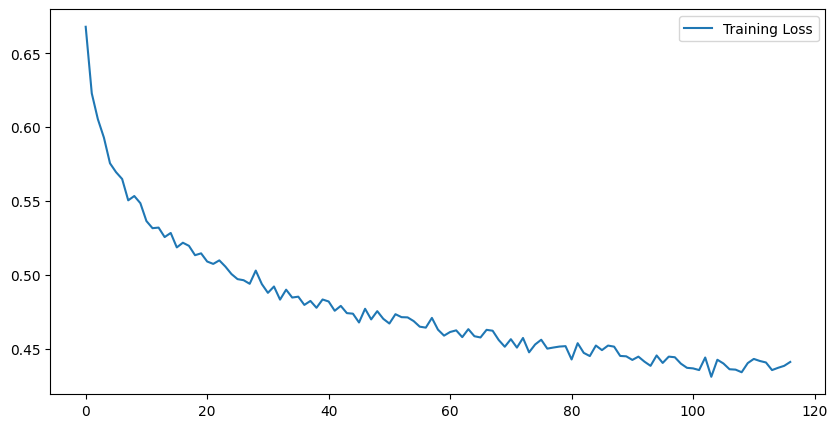

In [86]:
fig, ax=plt.subplots(figsize=(10,5))
ax.plot(m_loss['train'], label="Training Loss")
ax.legend()
plt.show()

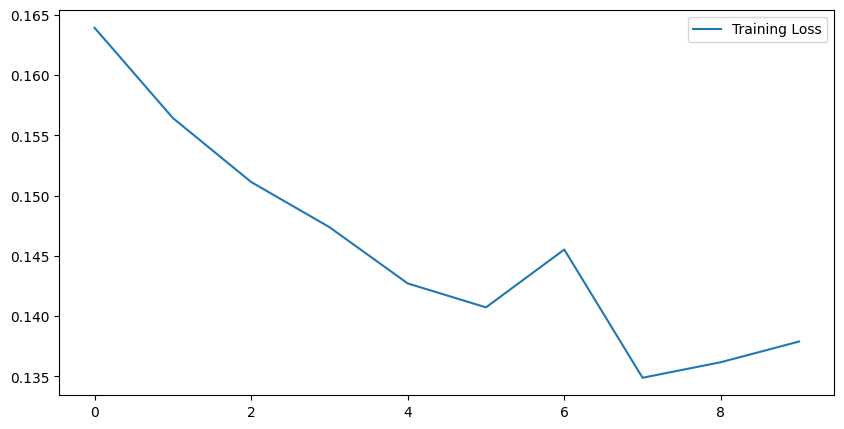

In [87]:
fig, ax=plt.subplots(figsize=(10,5))
ax.plot(res_loss['train'], label="Training Loss")
ax.legend()
plt.show()

In [90]:
test_model(resnet)

correct: 2989  total: 5000
accuracy = 0.597800


# Same goes for the other model
## accuracy would've been way higher if i put in the mean and std for this model too. (it was pretrained on ImageNet)

In [ ]:
googlenet.to(device)
goo_loss = train_model(googlenet)